# Getting Started

Natural Language Processing with Disaster Tweets is a Kaggle Challenge where tweets are collected with labels indicating whether the tweets are about a disaster that occurred or not. Since tweets are social media language, therefore, it is a challenge to automatically identify them. Besides, ambiguity in texts makes it more difficult to achieve automatic identification of tweets containing information on real disaster. The objective of this project is to predict using machine learning if a tweet contains information on occurrence of a real disaster or not.

Data Source - https://www.kaggle.com/c/nlp-getting-started

## Imports

In [146]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['font.size'] = 15

from collections import Counter
from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator
import contractions
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, QuantileTransformer, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

## Data Load

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Exploratory Data Analysis

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_train.shape

(7613, 5)

In [5]:
for col in df_train.columns:
    print("{} has {} unique instances".format(col, len(df_train[col].unique())))

id has 7613 unique instances
keyword has 222 unique instances
location has 3342 unique instances
text has 7503 unique instances
target has 2 unique instances


There are 7613 unique ids which is in accordance with the dataframe shape.

Target has two classes. This is expected since this is a binary classification task

In [6]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df_train.isnull().sum() * 100  / len(df_train)

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

Keyword and location has missing values. Location has 33% data missing. This missing data could be atckled by detecting location in tweets and filling them up. I will not be doing this since I will be using tf-idf on the tweet text joined with location. Therefore, this step is not required for modelling though could be useful for EDA.  

In [8]:
df_train[~df_train['location'].isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


Evident that the location information is not consistant. It is also possible to extract location information from text as in id 50.

In [9]:
df_train[df_train['id'] == 48]['text']

31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
Name: text, dtype: object

## Column Names - STATIC

I prefer standardizing column names:

In [10]:
KEYWORD = 'keyword'
ID = 'id'
LOCATION = 'location'
TEXT = 'text'
TARGET = 'target'
_TEXT_SPACY_OBJ_ = '_TEXT_SPACY_OBJ_'
SENTIMENT = 'Sentiment Score'
SENTIMENT_ROUND = 'Sentiment Score (rounded off)'
_LOCATION_ = '_location_'
_LOC_POINT = '_loc_point'
_WORDS_PER_TWEET_ = 'Words Per Tweet'
_CHAR_PER_TWEET_ = 'Characters Per Tweet'
_LOC_SPACY_OBJ_ = '_LOC_SPACY_OBJ_'
ALL_TEXT = 'all_text'
ALL_TEXT_JOINED = 'all_text_joined'
NUM_IN_TWEETS = 'Number in Tweet'
PUNCTUATION_COUNT = 'Punctuation Count Per Tweet'
IDENTIFIABLE_LOCATION = 'Identifiable Location'
IN_BOW = 'Present In BOW'

## Keyword Analysis

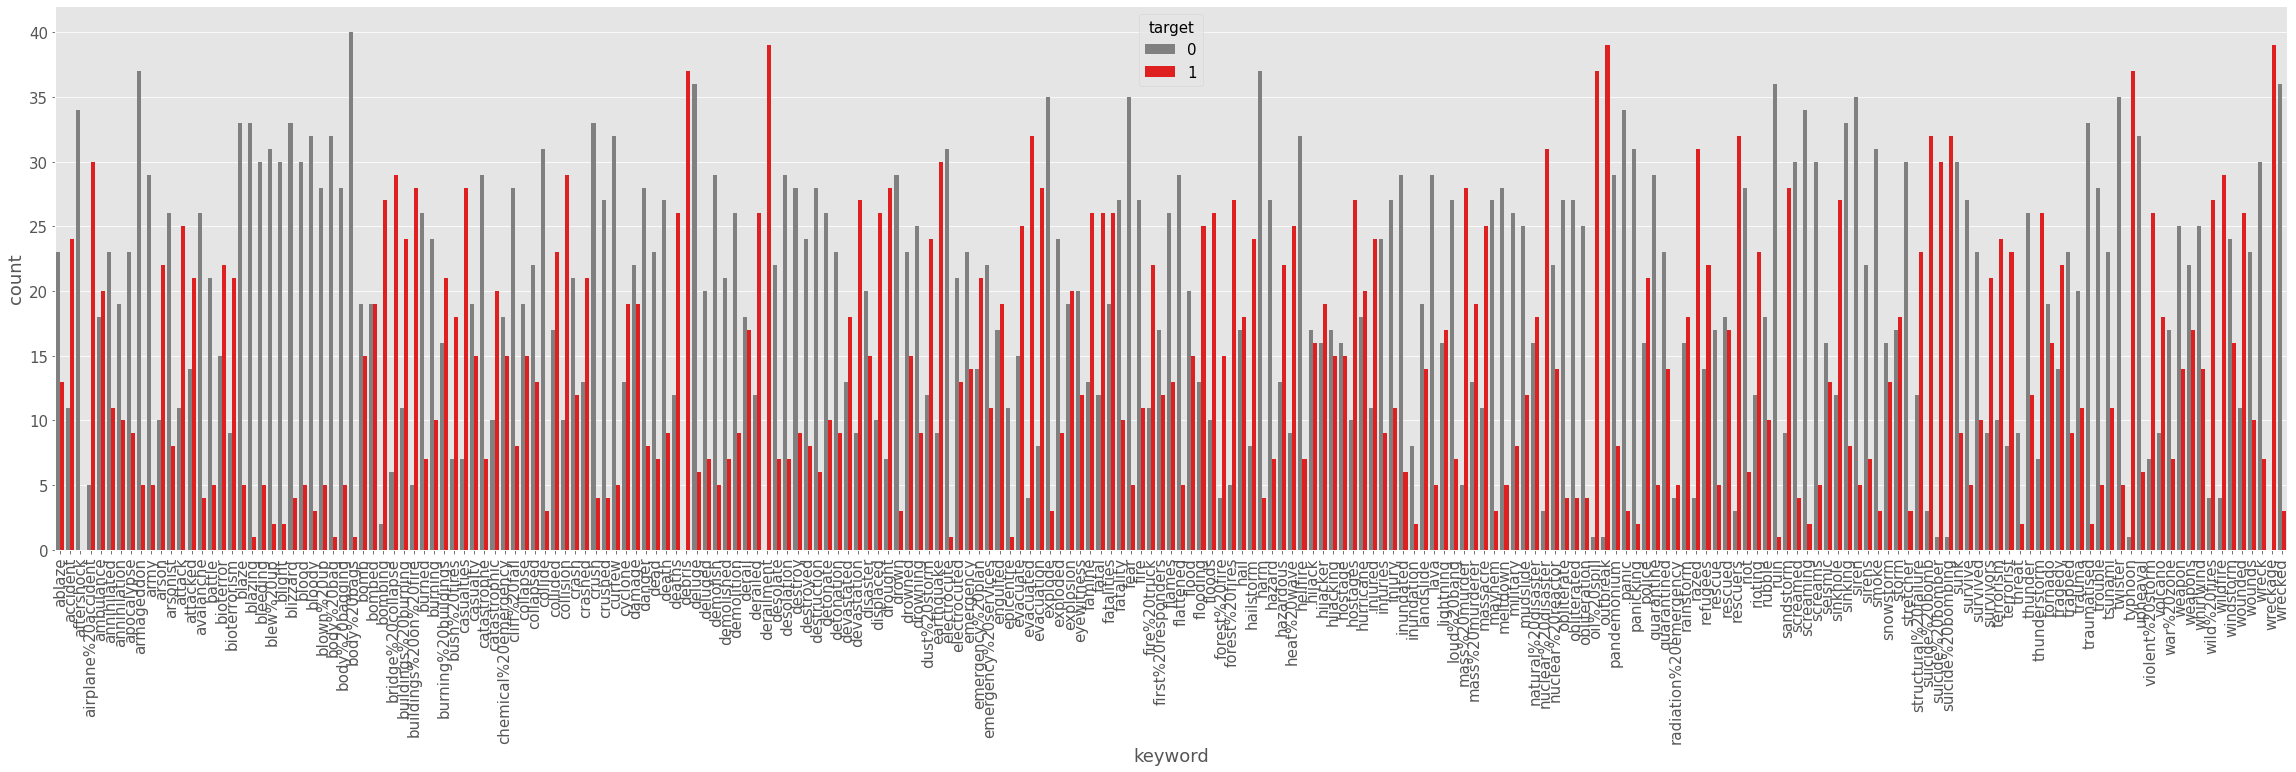

In [11]:
plt.figure(figsize=[40, 10])
sns.countplot(x=KEYWORD, hue=TARGET, data=df_train, palette=['grey', 'red'])
plt.xticks(rotation=90)
plt.show()

Blank spaces indicated by %20. Will require to clean this.

From this chart, it is seen that 'derailment', 'debris' and 'wreckage' are all about real disaster tweets. Body20%bags contains the higest difference between real and non-real disaster tweets where the number of non-real disaster tweets is high. It is actually the highest.

In [12]:
df_train[(df_train[KEYWORD] == 'body%20bags') & (df_train[TARGET] == 1)][TEXT].values

array(['@FoxNews @JenGriffinFNC When you call to report dangerous activity tell em to have body bags on arrival.'],
      dtype=object)

## Target Imabalance

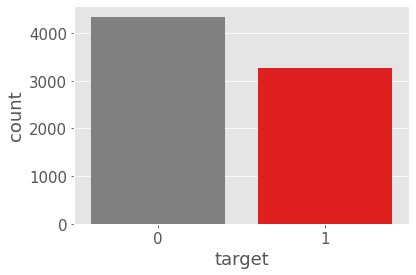

In [13]:
sns.countplot(x=TARGET, data=df_train, palette=['grey', 'red'])
plt.show()

This dataset is imbalanced. The disprity is of ~1000 datapoints where the number of non-disastrous tweets are higher.

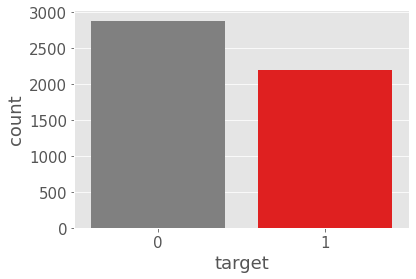

In [14]:
sns.countplot(x=TARGET, data=df_train[~df_train[LOCATION].isna()], palette=['grey', 'red'])
plt.show()

For the tweets whose location is NOT missing, the data imabalance is true in this case as well. Therefore, dropping the location null data will not help balancing the data.

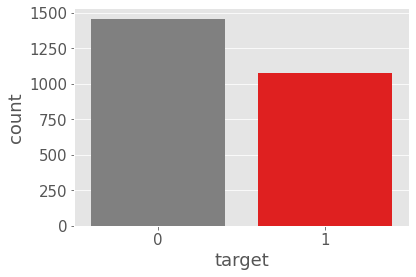

In [15]:
sns.countplot(x=TARGET, data=df_train[df_train[LOCATION].isna()], palette=['grey', 'red'])
plt.show()

For the tweets whose location is missing, the data imabalance is true in this case as well.

## Top 20 locations

In [16]:
df_train[df_train[TARGET] == 1].groupby(LOCATION)[TARGET].count().reset_index()

,location,target
0,,1
1,News,1
2,"616 Û¢ Kentwood , MI",1
3,? ??????? ? ( ?? å¡ ? ? ? å¡),1
4,Alberta,1
...,...,...
1508,"ÌÏT: 40.562796,-75.488849",1
1509,"ÌÏT: 41.252426,-96.072013",1
1510,"ÌÏT: 6.4682,3.18287",1
1511,"ÌÏT: 6.488400524109015,3.352798039832285",1


In [17]:
df_train[df_train[TARGET] == 1].groupby(
    LOCATION)[TARGET].count().reset_index().sort_values(by=TARGET)

,location,target
0,,1
979,Porthcawl,1
978,"Portage, IN / Worldwide",1
977,Port Williams NS,1
976,"Port Orange, FL",1
...,...,...
787,Mumbai,19
576,India,20
857,Nigeria,22
1258,United States,27


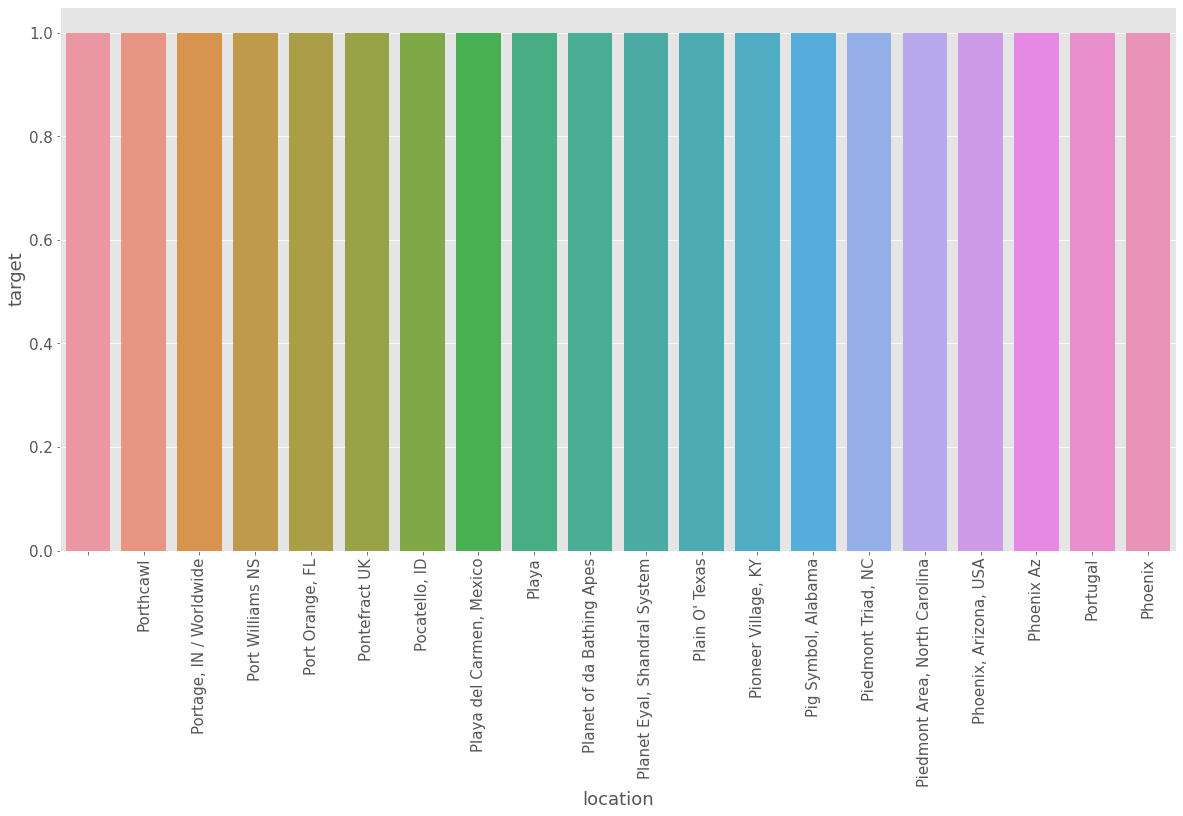

In [18]:
plt.figure(figsize=[20, 10])
sns.barplot(x=LOCATION,
            y=TARGET,
            data=df_train[df_train[TARGET] == 1].groupby(LOCATION)
            [TARGET].count().reset_index().sort_values(by=TARGET)[:20])
plt.xticks(rotation=90)
plt.show()

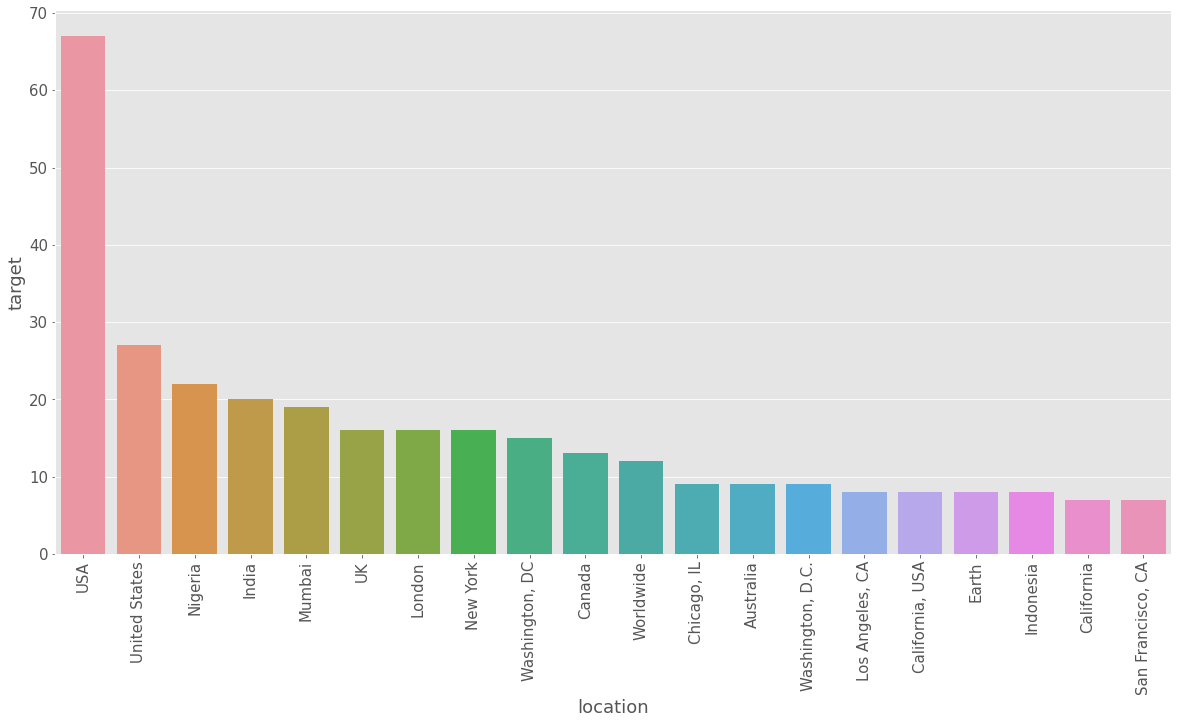

In [19]:
plt.figure(figsize=[20, 10])
sns.barplot(x=LOCATION,
            y=TARGET,
            data=df_train[df_train[TARGET] == 1].groupby(LOCATION)
            [TARGET].count().reset_index().sort_values(by=TARGET,
                                                       ascending=False)[:20])
plt.xticks(rotation=90)
plt.show()

There is an overlap of countries, cities and there are also co-ordinate information plus some gibberish data.

## Text Check

Here is have random tweet text checks  to see what is in there

In [20]:
df_train[TEXT][8], df_train[TARGET][8]

("There's an emergency evacuation happening now in the building across the street",
 1)

In [21]:
df_train[TEXT][20], df_train[TARGET][20]

('this is ridiculous....', 0)

In [22]:
df_train[TEXT][1000] , df_train[TARGET][1000]

('#OVOFest Drake straight body bagging Meek on that OVO stage. #ZIPHIMUP!', 0)

In [23]:
df_train[TEXT][2000] , df_train[TARGET][2000]

('@BradleyBrad47 the saw is fast af and does great damage i upgraded it a shitton and used it exclusively for a whole playthrough',
 0)

## Test Data Check

In [24]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [25]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

**Notes:**

To remove:
1. urls from the texts, 
2. html tags
3. mentions using @.
4. %20 from keywords

Will retain hashtags since importance information lies in hasgtags but will remove the # in them.

# Basic Cleaning

## Cleaning Tests

In [26]:
test_string = 'I am at https://www.nabanita.org www.nabanita.org okay'
url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
test_op = re.sub(url_pattern, '', test_string)
test_op

'I am at   okay'

In [27]:
test_string = 'I am at <p>www.nabanita.org &nbsp;</p>'
html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at www.nabanita.org '

In [28]:
test_string = 'I am at <p>www.nabanita.org'
html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at www.nabanita.org'

In [29]:
test_string = 'I am at @nabanita #python testing 123'
html_entities = r'@([a-z0-9]+)|#'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at  python testing 123'

A tweet might tag news channels as well which contains the word 'news'. If they are twitter handles, then the information will be lost. Hence adding this function to add the keyword news to the tweet if the word is present in the tweet text.

## Implementation

In [170]:
def remove_urls(text):
    ''' This method takes in text to remove urls and website links, if any'''
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)
    return text

def remove_html_entities(text):
    ''' This method removes html tags'''
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    text = re.sub(html_entities, '', text)
    return text

def convert_lower_case(text):
    return text.lower()

def detect_news(text):
    if 'news' in text:
        text = text + ' news'
    return text

def remove_social_media_tags(text):
    ''' This method removes @ and # tags'''
    tag_pattern = r'@([a-z0-9]+)|#'
    text = re.sub(tag_pattern, '', text)
    return text

# Count it before I remove them altogether
def count_punctuations(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?',text)
    return len(getpunctuation)


def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append(contractions.fix(each_word).lower())
    word_list = [porter_stemmer.stem(each_word.replace('\n', '').strip()) for each_word in word_list]
    word_list = set(word_list) - set(STOPWORDS)
    return " ".join(word_list)

In [171]:
porter_stemmer = PorterStemmer()

df_train[TEXT] = df_train[TEXT].apply(remove_urls)
df_train[TEXT] = df_train[TEXT].apply(remove_html_entities)
df_train[TEXT] = df_train[TEXT].apply(convert_lower_case)
df_train[TEXT] = df_train[TEXT].apply(detect_news)
df_train[TEXT] = df_train[TEXT].apply(remove_social_media_tags)
df_train[PUNCTUATION_COUNT] = df_train[TEXT].apply(count_punctuations)
df_train[TEXT] = df_train[TEXT].apply(preprocess_text)

In [172]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),_LOC_SPACY_OBJ_,Identifiable Location,_TEXT_SPACY_OBJ_,Words Per Tweet,Characters Per Tweet,Present In BOW,all_text,all_text_joined
0,1,NaN,,forgiv reason allah earthquak us may deed,1,0,0,0.0,0,(),0,"(forgiv, reason, allah, earthquak, us, may, deed)",7,41,1,"[forgiv, reason, allah, earthquak, us, may, deed]",forgiv reason allah earthquak us may deed
1,4,NaN,,rong fire canada forest near la sask,1,0,0,0.1,0,(),0,"(rong, fire, canada, forest, near, la, sask)",7,36,1,"[rong, fire, canada, forest, near, la, sask]",rong fire canada forest near la sask
2,5,NaN,,offic notifi resid place order evacu expect sh...,1,0,0,-0.1,0,(),0,"(offic, notifi, resid, place, order, evacu, ex...",9,55,1,"[offic, notifi, resid, place, order, evacu, ex...",offic notifi resid place order evacu expect sh...
3,6,NaN,,peopl 13000 order evacu receiv california wil...,1,0,1,0.0,0,(),0,"( , peopl, 13000, order, evacu, receiv, califo...",8,50,1,"[ , peopl, 13000, order, evacu, receiv, califo...",peopl 13000 order evacu receiv california wi...
4,7,NaN,,pour rubi sent got smoke alaska school photo ...,1,0,0,0.0,0,(),0,"( , pour, rubi, sent, got, smoke, alaska, scho...",10,53,0,"[ , pour, rubi, sent, got, smoke, alaska, scho...",pour rubi sent got smoke alaska school photo...


In [33]:
# Test

# Expected to remove @FoxNews but have ' news' in the tweet text

df_train[(df_train[KEYWORD] == 'body%20bags') & (df_train[TARGET] == 1)][TEXT].values

array([' report activity dangerous call arrival body news tell bags'],
      dtype=object)

## Punctuation Analysis

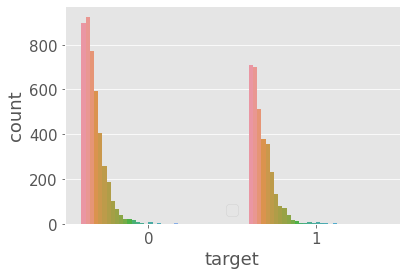

In [34]:
sns.countplot(x=TARGET, hue=PUNCTUATION_COUNT, data=df_train)
plt.legend([])
plt.show()

In [35]:
def clean_keyword(text):
    if text is not np.nan and text:
        text = text.replace('%20', ' ')
    return text

In [36]:
df_train[KEYWORD] = df_train[KEYWORD].apply(clean_keyword)

## Keyword Check

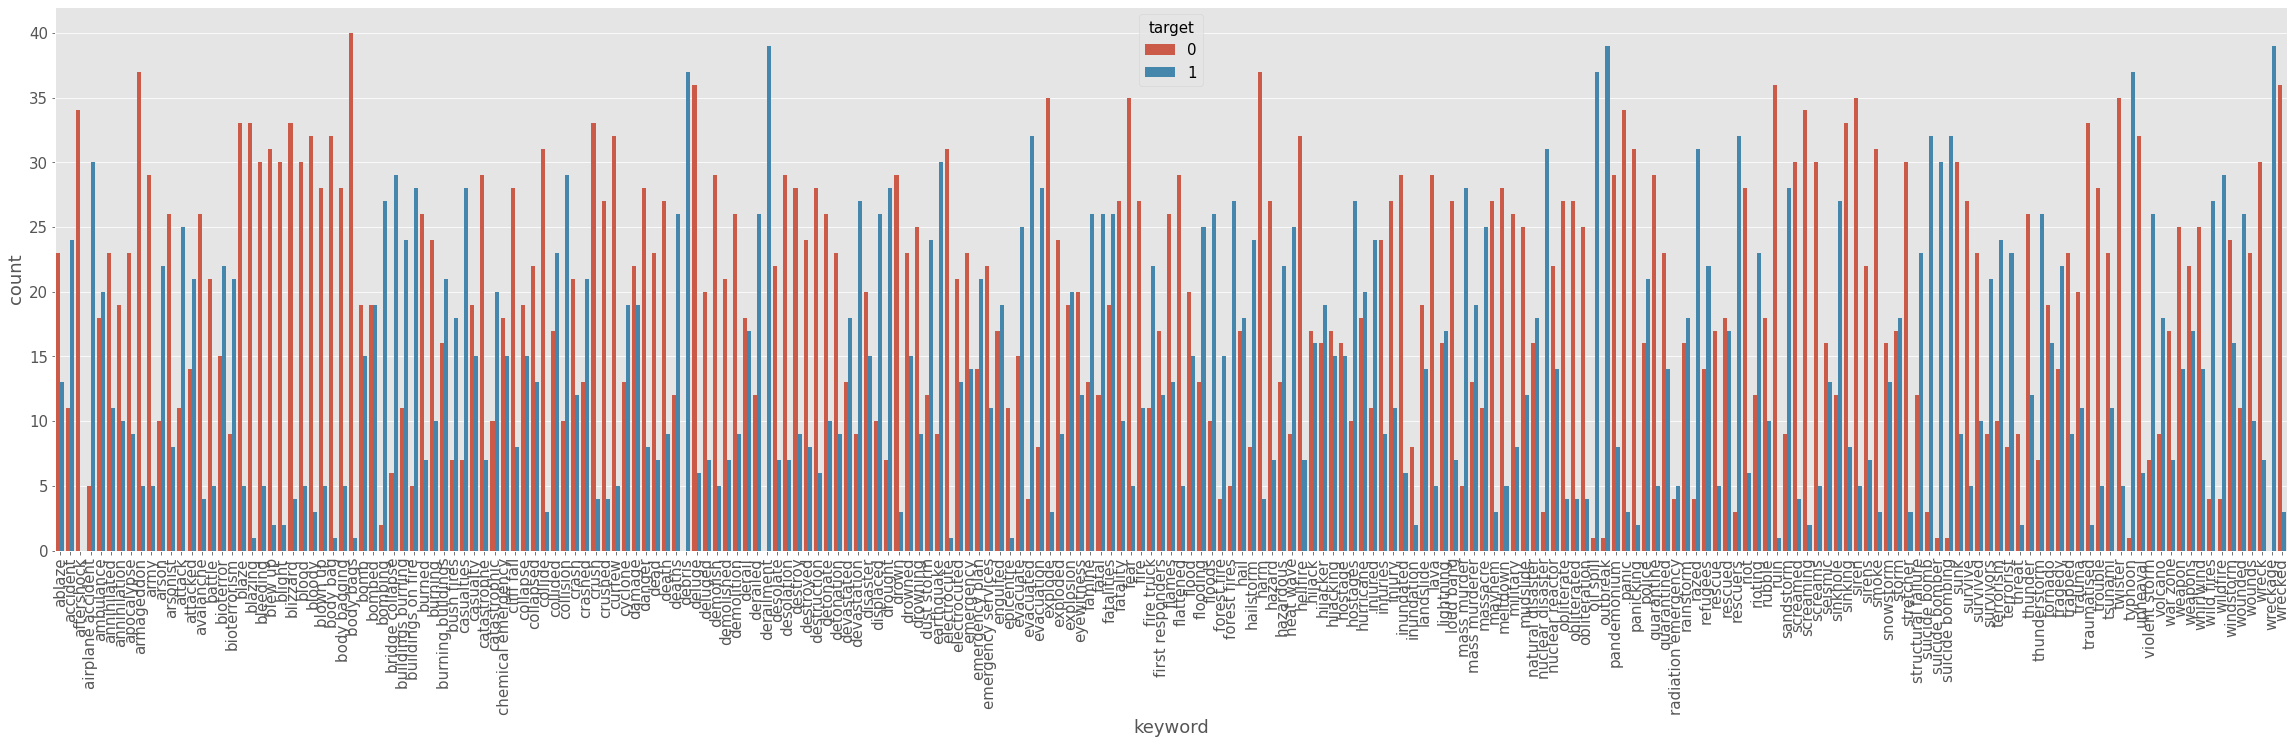

In [37]:
# Testing if %20 is replaced by space

plt.figure(figsize=[40, 10])
sns.countplot(x=KEYWORD, hue=TARGET, data=df_train, palette=['grey', 'red'])
plt.xticks(rotation=90)
plt.show()

# Mention of Numbers in Tweets

In [38]:
def get_numbers_in_tweet(text):
    list_numbers = re.findall(r'\d+', text)
    if list_numbers:
        return 1
    return 0

In [39]:
df_train[NUM_IN_TWEETS] = df_train[TEXT].apply(get_numbers_in_tweet)

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           7613 non-null   int64 
 1   keyword                      7552 non-null   object
 2   location                     5080 non-null   object
 3   text                         7613 non-null   object
 4   target                       7613 non-null   int64 
 5   Punctuation Count Per Tweet  7613 non-null   int64 
 6   Number in Tweet              7613 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 416.5+ KB


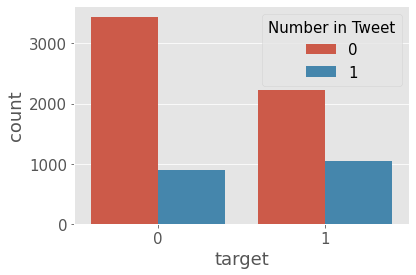

In [41]:
sns.countplot(x=TARGET, hue=NUM_IN_TWEETS, data=df_train)
plt.show()

The probability of having numbers in tweets about real disasters.

# Sentiment Analysis

In [42]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [43]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [44]:
df_train[SENTIMENT] = df_train[TEXT].apply(lambda x: nlp(x)._.polarity)

In [45]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score
0,1,NaN,NaN,reason allah us earthquake may deeds forgive,1,0,0,0.0
1,4,NaN,NaN,ronge fire canada forest near la sask,1,1,0,0.1
2,5,NaN,NaN,evacuation officers expected place notified as...,1,3,0,-0.1
3,6,NaN,NaN,people evacuation receive wildfires 13000 cal...,1,1,1,0.0
4,7,NaN,NaN,wildfires ruby sent got smoke pours alaska sc...,1,0,0,0.0


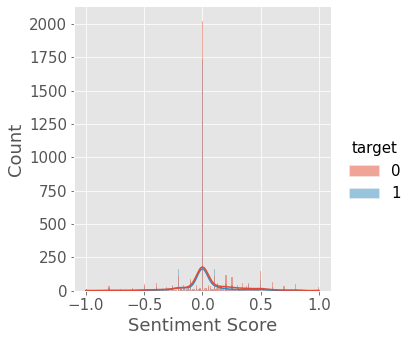

In [46]:
sns.displot(x=SENTIMENT, hue=TARGET, data=df_train, kde=True)
plt.show()

In [47]:
df_train[SENTIMENT_ROUND] = df_train[SENTIMENT].apply(round)
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off)
0,1,NaN,NaN,reason allah us earthquake may deeds forgive,1,0,0,0.0,0
1,4,NaN,NaN,ronge fire canada forest near la sask,1,1,0,0.1,0
2,5,NaN,NaN,evacuation officers expected place notified as...,1,3,0,-0.1,0
3,6,NaN,NaN,people evacuation receive wildfires 13000 cal...,1,1,1,0.0,0
4,7,NaN,NaN,wildfires ruby sent got smoke pours alaska sc...,1,0,0,0.0,0


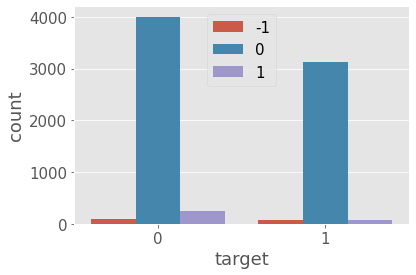

In [48]:
sns.countplot(x=TARGET, hue=SENTIMENT_ROUND, data=df_train)
plt.legend()
plt.show()

Since this data will be used later for modelling, I will use a label encoder in the pipeline to get rid of the negative number.

# Location Analysis

In [49]:
# import time
# from geopy.geocoders import Nominatim

# geolocator = Nominatim(user_agent="my_app")

# def print_location(loc):
#     if loc:
#         try:
#             location = geolocator.geocode(loc)
#             return location
#         except:
#             time.sleep(1)
#             try:
#                 location = geolocator.geocode(loc)
#                 return location
#             except:
#                 print(loc)

# df_train[_LOCATION_] = df_train[LOCATION].apply(lambda x: print_location(x))
# df_train.head()

In [50]:
def check_location(spacy_loc):
    ''' This method checks if the tweet location has any actual location 
    and saves them as as space-separated value if more than one.
    If no location is found, then save blank'''
    num_loc_in_tweet = len([ent.label_ for ent in spacy_loc.ents if ent.label_ == 'GPE'])
    if num_loc_in_tweet:
        locs_in_tweet = [ent.text for ent in spacy_loc.ents if ent.label_ == 'GPE']
    else:
        return nlp(''), 0
    return nlp(' '.join(locs_in_tweet)), 1

df_train[LOCATION].fillna('', inplace=True)
df_train[_LOC_SPACY_OBJ_] = df_train[LOCATION].apply(nlp)
df_train[_LOC_SPACY_OBJ_], df_train[IDENTIFIABLE_LOCATION] = zip(*df_train[_LOC_SPACY_OBJ_].apply(check_location))

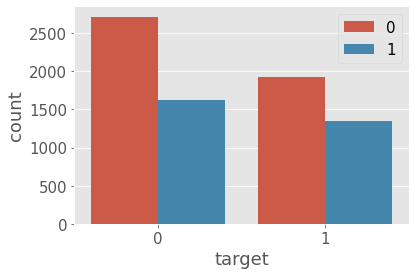

In [51]:
sns.countplot(x=TARGET, hue=IDENTIFIABLE_LOCATION, data=df_train)
plt.legend()
plt.show()

# Tweet Length Analysis

In [155]:
df_train[_TEXT_SPACY_OBJ_] = df_train[TEXT].apply(nlp)

In [53]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),_LOC_SPACY_OBJ_,Identifiable Location,_TEXT_SPACY_OBJ_
0,1,NaN,,reason allah us earthquake may deeds forgive,1,0,0,0.0,0,(),0,"(reason, allah, us, earthquake, may, deeds, fo..."
1,4,NaN,,ronge fire canada forest near la sask,1,1,0,0.1,0,(),0,"(ronge, fire, canada, forest, near, la, sask)"
2,5,NaN,,evacuation officers expected place notified as...,1,3,0,-0.1,0,(),0,"(evacuation, officers, expected, place, notifi..."
3,6,NaN,,people evacuation receive wildfires 13000 cal...,1,1,1,0.0,0,(),0,"(people, , evacuation, receive, wildfires, 13..."
4,7,NaN,,wildfires ruby sent got smoke pours alaska sc...,1,0,0,0.0,0,(),0,"( , wildfires, ruby, sent, got, smoke, pours, ..."


In [156]:
df_train[_WORDS_PER_TWEET_] = df_train[_TEXT_SPACY_OBJ_].apply(len)
df_train[_CHAR_PER_TWEET_] = df_train[TEXT].apply(len)

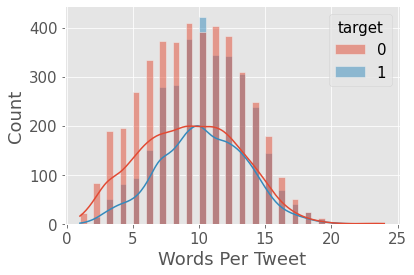

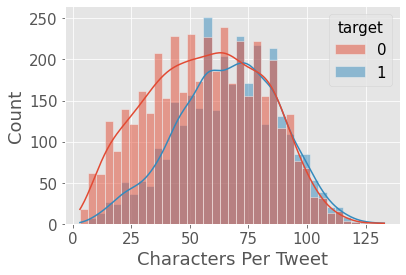

In [55]:
sns.histplot(x=_WORDS_PER_TWEET_, hue=TARGET, data=df_train, kde=True)
plt.show()
sns.histplot(x=_CHAR_PER_TWEET_, hue=TARGET, data=df_train, kde=True)
plt.show()

# Tweet Text Analysis using WordCloud

In [56]:
real_disaster_tweets = ' '. join(list(df_train[df_train[TARGET] == 1][TEXT]))

In [57]:
non_real_disaster_tweets = ' '. join(list(df_train[df_train[TARGET] == 0][TEXT]))

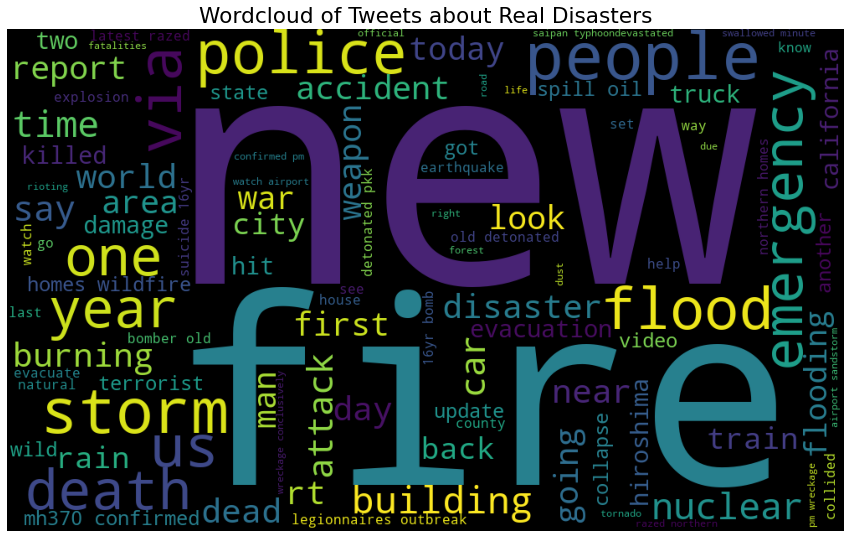

In [58]:
wc = WordCloud(background_color="black", 
               max_words=100, 
               width=1000, 
               height=600, 
               random_state=1).generate(real_disaster_tweets)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Wordcloud of Tweets about Real Disasters")
plt.show()

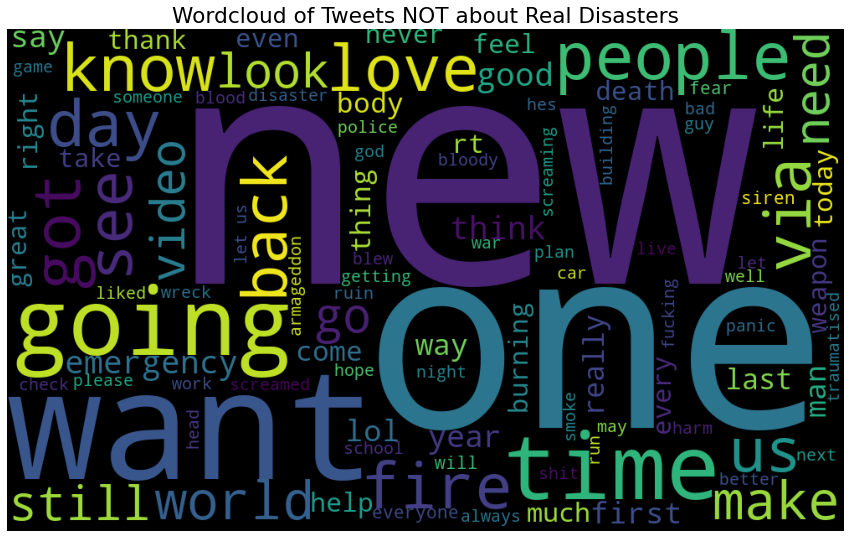

In [59]:
wc = WordCloud(background_color="black", 
               max_words=100, 
               width=1000, 
               height=600,
               font_step=1,
               random_state=1).generate(non_real_disaster_tweets)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Wordcloud of Tweets NOT about Real Disasters")
plt.show()

Emojis are present in the text, as evident on the wordcloud. Therefore, they need to be either detected or removed. I will not be addressing emoji detection in this project.

In [60]:
from collections import Counter
term_freq = dict(Counter(real_disaster_tweets.split(' ')))
sorted_terms_freq = dict(sorted(term_freq.items(), key=lambda x: x[1], reverse=True))
bow = [k for k, v in sorted_terms_freq.items() if v > 35]  # To check the words appearing to create the below list.

In [61]:
bow = [
    'news', 'fire', 'suicide', 'disaster', 'killed', 'storm', 'crash',
    'emergency', 'bomb', 'nuclear', 'wildfire', 'accident', 'bombing',
    'attack', 'burning', 'dead', 'bomber', 'war', 'families', 'atomic',
    'fatal', 'collapse', 'debris', 'water', 'mass', 'severe', 'warning',
    'injured', 'oil', 'spill', 'floods', 'wreckage', 'earthquake',
    'evacuation', 'derailment', 'outbreak', 'thunderstorm', 'flood', 'missing',
    'flooding'
]

def is_word_in_bow(x):
    for word in x.split(' '):
        if word in bow:
            return 1
    return 0

df_train[IN_BOW] = df_train[TEXT].apply(is_word_in_bow)

<AxesSubplot:xlabel='Present In BOW', ylabel='count'>

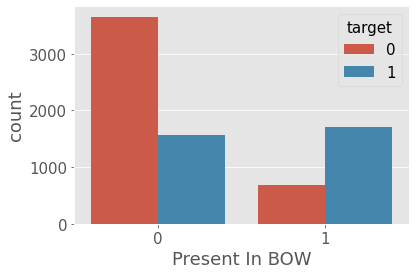

In [62]:
sns.countplot(data=df_train, x=IN_BOW, hue=TARGET)

# Correlation between Tweet Length and Punctuation Count

<AxesSubplot:>

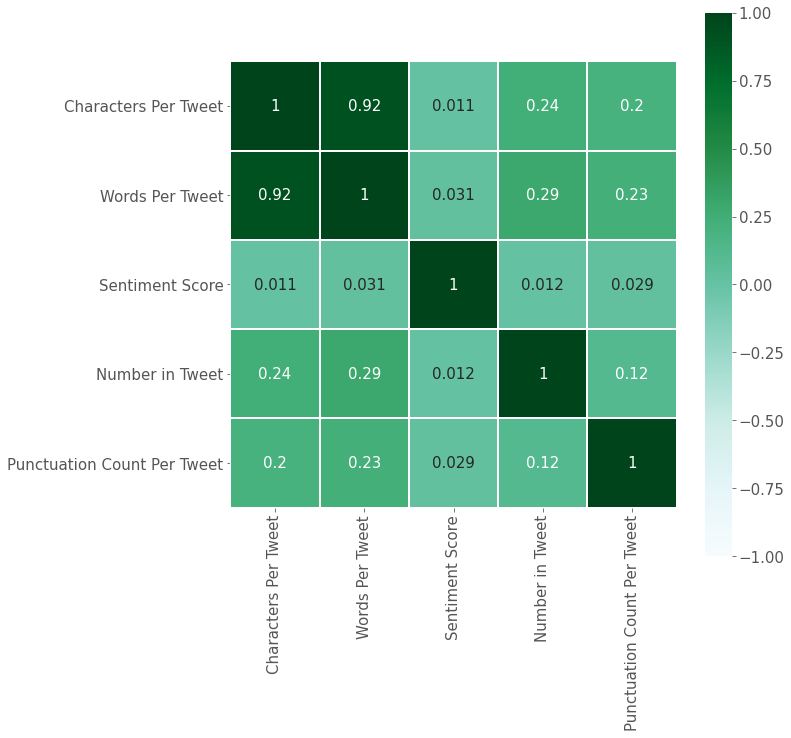

In [63]:
plt.figure(figsize=[10,10])
sns.heatmap(df_train[[_CHAR_PER_TWEET_, _WORDS_PER_TWEET_, SENTIMENT, NUM_IN_TWEETS , PUNCTUATION_COUNT]].corr(),
            annot=True, square=True, vmin=-1, vmax=1, linewidths=1, cmap='BuGn'
           )

# Data Modelling

In [64]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),_LOC_SPACY_OBJ_,Identifiable Location,_TEXT_SPACY_OBJ_,Words Per Tweet,Characters Per Tweet,Present In BOW
0,1,NaN,,reason allah us earthquake may deeds forgive,1,0,0,0.0,0,(),0,"(reason, allah, us, earthquake, may, deeds, fo...",7,44,1
1,4,NaN,,ronge fire canada forest near la sask,1,1,0,0.1,0,(),0,"(ronge, fire, canada, forest, near, la, sask)",7,37,1
2,5,NaN,,evacuation officers expected place notified as...,1,3,0,-0.1,0,(),0,"(evacuation, officers, expected, place, notifi...",9,74,1
3,6,NaN,,people evacuation receive wildfires 13000 cal...,1,1,1,0.0,0,(),0,"(people, , evacuation, receive, wildfires, 13...",8,60,1
4,7,NaN,,wildfires ruby sent got smoke pours alaska sc...,1,0,0,0.0,0,(),0,"( , wildfires, ruby, sent, got, smoke, pours, ...",10,56,0


In [157]:
from spacy.tokens import Doc
df_train[ALL_TEXT] = df_train.apply(lambda x: Doc.from_docs([x[_TEXT_SPACY_OBJ_], x[_LOC_SPACY_OBJ_]]), axis=1)
df_train[ALL_TEXT] = df_train[ALL_TEXT].apply(lambda x: [token.text for token in x])

In [66]:
df_train.head(2)

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),_LOC_SPACY_OBJ_,Identifiable Location,_TEXT_SPACY_OBJ_,Words Per Tweet,Characters Per Tweet,Present In BOW,all_text
0,1,NaN,,reason allah us earthquake may deeds forgive,1,0,0,0.0,0,(),0,"(reason, allah, us, earthquake, may, deeds, fo...",7,44,1,"[reason, allah, us, earthquake, may, deeds, fo..."
1,4,NaN,,ronge fire canada forest near la sask,1,1,0,0.1,0,(),0,"(ronge, fire, canada, forest, near, la, sask)",7,37,1,"[ronge, fire, canada, forest, near, la, sask]"


In [158]:
target = df_train[TARGET].values
df_train[ALL_TEXT_JOINED] = df_train[ALL_TEXT].apply(lambda x: " ".join(x))

The training data is ready now. Next step, prepping the test data.

# Test Data Preparation

In [68]:
df_test[TEXT] = df_test[TEXT].apply(remove_urls)
df_test[TEXT] = df_test[TEXT].apply(remove_html_entities)
df_test[TEXT] = df_test[TEXT].apply(convert_lower_case)
df_test[TEXT] = df_test[TEXT].apply(detect_news)
df_test[TEXT] = df_test[TEXT].apply(remove_social_media_tags)
df_test[PUNCTUATION_COUNT] = df_test[TEXT].apply(count_punctuations)
df_test[TEXT] = df_test[TEXT].apply(preprocess_text)

df_test[KEYWORD] = df_test[KEYWORD].apply(clean_keyword)

df_test[NUM_IN_TWEETS] = df_test[TEXT].apply(get_numbers_in_tweet)
df_test[SENTIMENT] = df_test[TEXT].apply(lambda x: nlp(x)._.polarity)
df_test[SENTIMENT_ROUND] = df_test[SENTIMENT].apply(round)

df_test[LOCATION].fillna('', inplace=True)
df_test[_LOC_SPACY_OBJ_] = df_test[LOCATION].apply(nlp)
df_test[_LOC_SPACY_OBJ_], df_test[IDENTIFIABLE_LOCATION] = zip(*df_test[_LOC_SPACY_OBJ_].apply(check_location))

df_test[_TEXT_SPACY_OBJ_] = df_test[TEXT].apply(nlp)

df_test[_WORDS_PER_TWEET_] = df_test[_TEXT_SPACY_OBJ_].apply(len)
df_test[_CHAR_PER_TWEET_] = df_test[TEXT].apply(len)

df_test[IN_BOW] = df_test[TEXT].apply(is_word_in_bow)

df_test[ALL_TEXT] = df_test.apply(lambda x: Doc.from_docs([x[_TEXT_SPACY_OBJ_], x[_LOC_SPACY_OBJ_]]), axis=1)
df_test[ALL_TEXT] = df_test[ALL_TEXT].apply(lambda x: [token.text for token in x])
df_test[ALL_TEXT_JOINED] = df_test[ALL_TEXT].apply(lambda x: " ".join(x))

The test data is ready now.

In [69]:
df_test.head()

,id,keyword,location,text,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),_LOC_SPACY_OBJ_,Identifiable Location,_TEXT_SPACY_OBJ_,Words Per Tweet,Characters Per Tweet,Present In BOW,all_text,all_text_joined
0,0,NaN,,terrible car happened crash,0,0,-1.00,-1,(),0,"(terrible, car, happened, crash)",4,27,1,"[terrible, car, happened, crash]",terrible car happened crash
1,2,NaN,,cities heard safe everyone earthquake differen...,2,0,0.25,0,(),0,"(cities, heard, safe, everyone, earthquake, di...",7,52,1,"[cities, heard, safe, everyone, earthquake, di...",cities heard safe everyone earthquake differen...
2,3,NaN,,fire pond forest spot cannot fleeing across sa...,2,0,0.00,0,(),0,"(fire, pond, forest, spot, can, not, fleeing, ...",11,61,1,"[fire, pond, forest, spot, can, not, fleeing, ...",fire pond forest spot can not fleeing across s...
3,9,NaN,,spokane lighting apocalypse wildfires,1,0,0.00,0,(),0,"(spokane, lighting, apocalypse, wildfires)",4,37,0,"[spokane, lighting, apocalypse, wildfires]",spokane lighting apocalypse wildfires
4,11,NaN,,28 taiwan kills typhoon soudelor china,0,1,0.00,0,(),0,"(28, taiwan, kills, typhoon, soudelor, china)",6,38,0,"[28, taiwan, kills, typhoon, soudelor, china]",28 taiwan kills typhoon soudelor china


In [70]:
df_test.describe()

,id,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),Identifiable Location,Words Per Tweet,Characters Per Tweet,Present In BOW
count,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000
mean,5427.152927,2.609255,0.259884,0.035408,0.013178,0.381244,9.783328,61.567269,0.304321
std,3146.427221,2.731204,0.438638,0.256215,0.247881,0.485767,3.608433,24.009061,0.460190
min,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,2683.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.000000,44.000000,0.000000
50%,5500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,10.000000,63.000000,0.000000
75%,8176.000000,4.000000,1.000000,0.100000,0.000000,1.000000,12.000000,80.000000,1.000000
max,10875.000000,50.000000,1.000000,1.000000,1.000000,1.000000,23.000000,125.000000,1.000000


# Building a Data Modeling Pipeline

## Baseline 

In [159]:
cols_to_train = [ALL_TEXT_JOINED]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    random_state=42)

pipe = Pipeline([('count_vec', CountVectorizer(ngram_range=(1, 2))),
                 ('tf_idf', TfidfTransformer(smooth_idf=False))])
ct = ColumnTransformer([("tf_idf", pipe, ALL_TEXT_JOINED)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [173]:
X_train_sparse.shape

(5709, 48128)

In [160]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
baseline_prediction = log_reg.predict(X_test_sparse)

In [161]:
def print_classification_metrics(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('f1-score: ', f1_score(y_test, y_pred))

In [162]:
print_classification_metrics(y_test, baseline_prediction)

Accuracy:  0.8025210084033614
Precision:  0.8266068759342302
Recall:  0.6801968019680197
f1-score:  0.7462887989203778


In [163]:
def predict_challenge_test_data(model, test_data, filename):
    submission_predictions = model.predict(test_data)
    df_submission = pd.read_csv('data/sample_submission.csv')
    df_submission[TARGET] = submission_predictions
    df_submission.to_csv(filename, index=False)

In [164]:
predict_challenge_test_data(log_reg, df_test_sparse, 'baseline_predictions_1.csv')

## Testing Random State Value

In [165]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_sparse, y_train)
baseline_prediction = log_reg.predict(X_test_sparse)
print_classification_metrics(y_test, baseline_prediction)

Accuracy:  0.8025210084033614
Precision:  0.8266068759342302
Recall:  0.6801968019680197
f1-score:  0.7462887989203778


## Testing Performance with CountVectorizer

In [129]:
cols_to_train = [ALL_TEXT_JOINED]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    random_state=42)

ct = ColumnTransformer([('count_vec', CountVectorizer(ngram_range=(1, 2)), ALL_TEXT_JOINED)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [131]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
baseline_prediction = log_reg.predict(X_test_sparse)
print_classification_metrics(y_test, baseline_prediction)

Accuracy:  0.8067226890756303
Precision:  0.8276877761413843
Recall:  0.6912669126691267
f1-score:  0.7533512064343163


**Onservations**

Using only CountVectorizer is yielding better results. Normalization is not helping in this case.

## Adding Other Features

Removed characters per tweet since it is strongly correlated with words per tweet. So, it doesn't make sense that I keep both.

In [178]:
# # TEST 1

# cols_to_train = [
#     ALL_TEXT_JOINED, SENTIMENT_ROUND, _WORDS_PER_TWEET_,
#     NUM_IN_TWEETS, PUNCTUATION_COUNT, IDENTIFIABLE_LOCATION, IN_BOW
# ] # avg ~ 74

# # TEST 2

cols_to_train = [
    ALL_TEXT_JOINED, SENTIMENT_ROUND, _WORDS_PER_TWEET_,
    NUM_IN_TWEETS, PUNCTUATION_COUNT, IDENTIFIABLE_LOCATION
] # avg ~ 76

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    random_state=42)

cols_to_scale = [_WORDS_PER_TWEET_, PUNCTUATION_COUNT]

ct = ColumnTransformer(
    [("scaler", StandardScaler(), cols_to_scale),
     ('one_hot_encoder', OneHotEncoder(drop='first', sparse=True), [SENTIMENT_ROUND]),
     ('count_vec', CountVectorizer() , ALL_TEXT_JOINED)],
    remainder='passthrough')

In [179]:
ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [143]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
all_cols_prediction = log_reg.predict(X_test_sparse)

In [144]:
print_classification_metrics(y_test, all_cols_prediction)

Accuracy:  0.8025210084033614
Precision:  0.7948717948717948
Recall:  0.7244772447724477
f1-score:  0.7580437580437579


In [136]:
predict_challenge_test_data(log_reg, df_test_sparse, 'test_predictions_1.csv')

**Observation**

Slight improvement in the f1-score using other features.

## Testing Scaling Strategies

In [120]:
list_scalers = [
    StandardScaler(),
    QuantileTransformer(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler()
]

for scaler in list_scalers:
    print(scaler)
    ct = ColumnTransformer(
        [("scaler", scaler, cols_to_scale),
         ('one_hot_encoder', OneHotEncoder(drop='first',
                                           sparse=True), [SENTIMENT_ROUND]),
         ("tf_idf", pipe_text, ALL_TEXT_JOINED)],
        remainder='passthrough')

    ct.fit(X_train)
    X_train_sparse = ct.transform(X_train)
    X_test_sparse = ct.transform(X_test)
    log_reg = LogisticRegression()
    log_reg.fit(X_train_sparse, y_train)
    all_cols_prediction = log_reg.predict(X_test_sparse)
    print_classification_metrics(y_test, all_cols_prediction)
    print('-------------------------')

StandardScaler()
Accuracy:  0.8119747899159664
Precision:  0.8340675477239354
Recall:  0.6986469864698647
f1-score:  0.7603748326639892
-------------------------
QuantileTransformer()
Accuracy:  0.8146008403361344
Precision:  0.8372434017595308
Recall:  0.7023370233702337
f1-score:  0.7638795986622074
-------------------------
MinMaxScaler()
Accuracy:  0.8140756302521008
Precision:  0.8350364963503649
Recall:  0.7035670356703567
f1-score:  0.7636849132176236
-------------------------
MaxAbsScaler()
Accuracy:  0.8140756302521008
Precision:  0.8350364963503649
Recall:  0.7035670356703567
f1-score:  0.7636849132176236
-------------------------
RobustScaler()
Accuracy:  0.8119747899159664
Precision:  0.8340675477239354
Recall:  0.6986469864698647
f1-score:  0.7603748326639892
-------------------------


**Observations**

Adding the IN_BOW features is likely overfitting the model and hence it is not performing well. Hence, I will exclude it. Among the scalers, Quantile Transformer is performing the best. Therefore, I will be using it.

## Testing Multiple Machine Learning Models

In [121]:
cols_to_train = [
    ALL_TEXT_JOINED, SENTIMENT_ROUND, _WORDS_PER_TWEET_,
    NUM_IN_TWEETS, PUNCTUATION_COUNT, IDENTIFIABLE_LOCATION
]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    random_state=42)

cols_to_scale = [_WORDS_PER_TWEET_, PUNCTUATION_COUNT]

pipe_text = Pipeline([('count_vec', CountVectorizer()),
                      ('tf_idf', TfidfTransformer(smooth_idf=False))])

ct = ColumnTransformer(
    [("scaler", QuantileTransformer(), cols_to_scale),
     ('one_hot_encoder', OneHotEncoder(drop='first', sparse=True), [SENTIMENT_ROUND]),
     ("tf_idf", pipe_text, ALL_TEXT_JOINED)],
    remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [122]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score'
])

In [123]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])
models_trained_list = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train_sparse, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test_sparse)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train_sparse, y_train),
        model.score(X_test_sparse, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

In [124]:
models_list = [LogisticRegression(),
               SVC(),
               KNeighborsClassifier(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               GradientBoostingClassifier()]

In [125]:
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 0.36 s.
Completed LogisticRegression model's performance assessment.
Training SVC model...
Completed SVC model training.
Time elapsed: 6.29 s.
Completed SVC model's performance assessment.
Training KNeighborsClassifier model...
Completed KNeighborsClassifier model training.
Time elapsed: 0.00 s.
Completed KNeighborsClassifier model's performance assessment.
Training DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Time elapsed: 1.86 s.
Completed DecisionTreeClassifier model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 8.14 s.
Completed RandomForestClassifier model's performance assessment.
Training GradientBoostingClassifier model...
Completed GradientBoostingClassifier model training.
Time elapsed: 2.89 s.
Completed GradientBoostingClassifier model's performance assessment.


In [126]:
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs
0,LogisticRegression,0.887721,0.814601,0.837243,0.702337,0.763880,0.36
1,SVC,0.900858,0.804097,0.883275,0.623616,0.731074,6.29
2,KNeighborsClassifier,0.801717,0.721113,0.679389,0.656827,0.667917,0.00
3,DecisionTreeClassifier,0.992293,0.712185,0.666667,0.651907,0.659204,1.86
4,RandomForestClassifier,0.991943,0.784139,0.806402,0.650677,0.720218,8.14
5,GradientBoostingClassifier,0.786302,0.746849,0.839836,0.503075,0.629231,2.89


In [127]:
predict_challenge_test_data(models_trained_list[0], df_test_sparse, 'test_predictions_2.csv')

# HyperParameter Tuning for Model Improvement

Random Forest Classifier is one of the competition winners and therefore I am curious if the F1-score could be improved with tuning the hyperparameters. It is also the one with the second highest F1 score with default configurations

## Random Forest Classifier

### Attempt 1

In [ ]:
max_depth = [5, 8, 15, 25, 30]
min_samples_leaf = [1, 2, 5, 10]
min_samples_split = [2, 5, 10, 15, 100]
n_estimators = [100, 300, 500, 800, 1200]

param_grid = dict(n_estimators=n_estimators,
                  max_depth = max_depth,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf
                 )

model = RandomForestClassifier()

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

In [ ]:
model_1 = grid_result.best_estimator_
y_pred_attempt_1 = model_1.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_1)
grid_result.best_params_

The results are poorer than the default configurations. 

So now, I will try with a set that narrows down to the best params here and also the boundaries of the lists which are the best params are expanded in the new grid.

### Attempt 2

In [ ]:
max_depth = [30, 50, 70 , 90]
min_samples_leaf = [1]
min_samples_split = [2]
n_estimators = [50, 100, 150]

param_grid = dict(max_depth=max_depth,
    n_estimators=n_estimators,min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf
                 )

model = RandomForestClassifier()

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train_sparse, y_train)

In [ ]:
model_2 = grid_result.best_estimator_
y_pred_attempt_2 = model_2.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_2)
grid_result.best_params_

### Attempt 3

There was slight improvement in the F1-score. So now, I wanted to see if keeping the best params from attempt 1 and keeping max_depth as 'auto' would be of any improvement or not. Hence, this smaller grid.

In [ ]:
min_samples_leaf = [1, 2, 3]
min_samples_split = [2, 10 ,20, 30]
n_estimators = [150, 200, 400, 600]

param_grid = dict(n_estimators=n_estimators,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf
                 )

model = RandomForestClassifier()

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

In [ ]:
model_3 = grid_result.best_estimator_
y_pred_attempt_3 = model_3.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_3)
grid_result.best_params_

There is significant improvement, more than the default configs and the grid results of attempt 1 and 2.

### Attempt 4

In this attempt, I tried to create a grid including the last two best set of params and adding some more trials, keeping max_depth as 'auto'.

In [ ]:
min_samples_leaf = [1, 2]
min_samples_split = [8, 10, 12, 14]
n_estimators = [350, 400, 450]

param_grid = dict(n_estimators=n_estimators,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf
                 )

model = RandomForestClassifier()

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

In [ ]:
model_4 = grid_result.best_estimator_
y_pred_attempt_4 = model_4.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_4)
grid_result.best_params_

The F1-score goes down this time. So from Random Forest, the best model is model 3.

## Logistic Regression

Proceeding onto logistic regression since it has the best F1 score so far. I start with the a sparse set of values for max_iter and C.

### Attempt 1

In [ ]:
max_iter = [100, 200, 500, 1000]
C = [0.1, 0.5, 1, 10, 50, 100]

param_grid = dict(max_iter=max_iter, C=C)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

In [ ]:
model_5 = grid_result.best_estimator_
y_pred_attempt_5 = model_5.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_5)
grid_result.best_params_

Logistic regression outperforms the tuned random forest as well as beats its own F1-score with default configs.

### Atempt 2

In this attempt, I have narowed down the grid values where the middle value is the previous best hyperparameter values.

In [ ]:
max_iter = [50, 100, 150]
C = [5, 10, 15, 20]

param_grid = dict(max_iter=max_iter, C=C)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

In [ ]:
model_6 = grid_result.best_estimator_
y_pred_attempt_6 = model_6.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_6)
grid_result.best_params_

There is a slight improvement in the F1 score.

### Attempt 3

In this atmmept, I tried different combinations of penalty, solver and fit_intercept to check if they could predict better.

In [ ]:
penalty = ['elasticnet', 'l1', 'l2']
solver = ['saga']
max_iter = [100, 200, 400, 500, 600, 1000]
C = [0.1, 0.5, 1, 10, 50, 100]
fit_intercept = [True, False]

param_grid = dict(max_iter=max_iter,
                  C=C,
                  penalty=penalty,
                  solver=solver,
                  fit_intercept=fit_intercept)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

In [ ]:
model_7 = grid_result.best_estimator_
y_pred_attempt_7 = model_7.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_7)
grid_result.best_params_

Again, there is slight improvment in the model performance.

### Attempt 4

In [ ]:
penalty = ['l1']
solver = ['saga', 'liblinear']
max_iter = [300, 400, 500]
C = [8, 10, 12]
fit_intercept = [False]

param_grid = dict(max_iter=max_iter,
                  C=C,
                  penalty=penalty,
                  solver=solver,
                  fit_intercept=fit_intercept)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

In [ ]:
model_8 = grid_result.best_estimator_
y_pred_attempt_8 = model_8.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_8)
grid_result.best_params_

The performance drops slightly.

### Atempt 5

This is my final attempt to tune C since the value of C changed from 10 to 8 in the last run. So now I am making more options around 8 and 10 for a final tuning process, keeping other best hyperparameter values from the previous attempt.

In [ ]:
penalty = ['l1']
solver = ['saga']
max_iter = [400]
C = [10, 11, 12, 13, 14]
fit_intercept = [False]

param_grid = dict(max_iter=max_iter,
                  C=C,
                  penalty=penalty,
                  solver=solver,
                  fit_intercept=fit_intercept)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

In [ ]:
model_9 = grid_result.best_estimator_
y_pred_attempt_9 = model_9.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_9)
grid_result.best_params_

Again the performance drop slightly. So the best performing model so far is Logistic Regression's attempt 3 and model 7.

# Kaggle Submissions

In [ ]:
predict_challenge_test_data(model_3, ct.transform(df_test[cols_to_train]), 'random_forest_predictions.csv')

In [ ]:
predict_challenge_test_data(model_7, ct.transform(df_test[cols_to_train]), 'log_reg_predictions.csv')

# Results Consolidated

F1 Scores for each attempt

1. Random Forest - 0.45
2. Random Forest - 0.72 (using 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 75)
3. Logistic Regression - 0.75
4. Logistic Regression - 0.75
5. Logistic Regression - 0.75 (Using C - 100 and max_iter - 50)